In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns

import pandas as pd
from sklearn import cluster, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torch.nn.functional as Func
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

In [2]:
# Load data
f = pd.read_csv("data.csv")
f.rename(columns={'time sample band g': 'time_g', 'time sample band r': 'time_r',
                    'time sample band i': 'time_i','total flux + noise band g': 'tfnbg',
                    'total flux + noise band r': 'tfnbr', 'total flux + noise band i': 'tfnbi',}, inplace=True)

In [3]:
f['images'] = f['images'].replace([1, 2, 3, 4], [0, 1, 1, 1])

In [4]:
train = f[:91*8000]
val = f[91*8000:91*9000]
test = f[91*9000:]

In [5]:
print((train['images']==0).sum())
print((train['images']==1).sum())


print((test['images']==0).sum())
print((test['images']==1).sum())

359541
368459
45591
45409


In [6]:
def dataframe_to_dataset(f):
        
    scaler = MinMaxScaler(feature_range = (0, 1), copy=False)
    #scaler = StandardScaler()

    features_columns = f.columns.tolist()[3::2]
    T = []
    F = []
    
    for ide, group in f.groupby('ID'):

        a = f[f.ID == ide]
        c = a[['ID', 'images']]
        data = a.copy()
        #t = ['time_g', 'time_r', 'time_i']
        
        data[['tfnbg', 'tfnbr', 'tfnbi']] = scaler.fit_transform(data[['tfnbg', 'tfnbr', 'tfnbi']])
        #data[t] = data[t]-np.min(data[t])

        T.append(a['images'].values[0])
        F.append(torch.tensor(data[features_columns].T.values)[None])

    
    T = torch.tensor(T)
    F = torch.cat(F, dim=0)
    print(F.shape)
    return TensorDataset(F.double(), T.double())

In [7]:
TrainSet = dataframe_to_dataset(train)
TestSet = dataframe_to_dataset(test)
ValSet = dataframe_to_dataset(val)

torch.Size([8000, 3, 91])
torch.Size([1000, 3, 91])
torch.Size([1000, 3, 91])


In [8]:
TrainSet

In [9]:
class SequenceModel(nn.Module):
    
    def __init__(self, n_channels, n_classes, n_hidden=64):
        
        super().__init__()
        
        self.conv1 = nn.Conv1d(3, 5, kernel_size=(5,))
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(5,20, kernel_size=(5,))
        #self.lstm1 = nn.Conv1d(
        #in_channels = n_features,
        #out_channels = n_hidden,
        #kernel_size = 5)
        #self.lstm1 = nn.LSTM(
        #    input_size = n_channels,
        #    hidden_size = n_hidden,
        #    num_layers = 5) 
        
        #self.lstm2 = nn.Conv1d(
        #in_channels = n_hidden,
        #out_channels = 128,
        #kernel_size = 5)
        
        
        self.c1 = nn.Linear(380, 64)
        self.c2 = nn.Linear(64, 10)
        self.c3 = nn.Linear(10, n_classes-1)
            
        
    def forward(self, x):
        #x, (ht, ct) = self.lstm1(x) 
        x = self.pool(Func.relu(self.conv1(x)))
        x = self.pool(Func.relu(self.conv2(x)))
        #x = self.lstm1(x)
        x = torch.flatten(x, 1)
        x= self.c1(x)
        x = self.c2(x)
        pred = self.c3(x)
        #pred = torch.sigmoid(pred)
        return pred

In [10]:
torch.manual_seed(0)

In [11]:
model = SequenceModel(n_channels = 3, 
                        n_classes = 2)
model = model.double()

In [12]:
print(model)

SequenceModel(
  (conv1): Conv1d(3, 5, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(5, 20, kernel_size=(5,), stride=(1,))
  (c1): Linear(in_features=380, out_features=64, bias=True)
  (c2): Linear(in_features=64, out_features=10, bias=True)
  (c3): Linear(in_features=10, out_features=1, bias=True)
)


In [13]:
TrainLoader = data_utils.DataLoader(TrainSet, batch_size = 5, shuffle = True)
ValLoader = data_utils.DataLoader(ValSet, batch_size = 16, shuffle = False)
TestLoader = data_utils.DataLoader(TestSet, batch_size = 16, shuffle = False)

In [14]:
loss_function = torch.nn.BCEWithLogitsLoss()

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [16]:
print("--- State_dict du model : ---")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print()

--- State_dict du model : ---
conv1.weight 	 torch.Size([5, 3, 5])
conv1.bias 	 torch.Size([5])
conv2.weight 	 torch.Size([20, 5, 5])
conv2.bias 	 torch.Size([20])
c1.weight 	 torch.Size([64, 380])
c1.bias 	 torch.Size([64])
c2.weight 	 torch.Size([10, 64])
c2.bias 	 torch.Size([10])
c3.weight 	 torch.Size([1, 10])
c3.bias 	 torch.Size([1])



Running epoch 1
[1,   100] loss: 0.69376, accuracy: -12.25000


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


[1,   200] loss: 0.68612, accuracy: -12.85000
[1,   300] loss: 0.67450, accuracy: -12.60000
[1,   400] loss: 0.65064, accuracy: -12.45000
[1,   500] loss: 0.60373, accuracy: -9.55000
[1,   600] loss: 0.54985, accuracy: -7.35000
[1,   700] loss: 0.47441, accuracy: -5.50000
[1,   800] loss: 0.43223, accuracy: -4.85000
[1,   900] loss: 0.37481, accuracy: -2.95000
[1,  1000] loss: 0.33527, accuracy: -3.15000
[1,  1100] loss: 0.30528, accuracy: -2.95000
[1,  1200] loss: 0.29244, accuracy: -2.70000
[1,  1300] loss: 0.27602, accuracy: -2.20000
[1,  1400] loss: 0.27766, accuracy: -2.55000
[1,  1500] loss: 0.24241, accuracy: -1.75000
[1,  1600] loss: 0.25048, accuracy: -2.15000


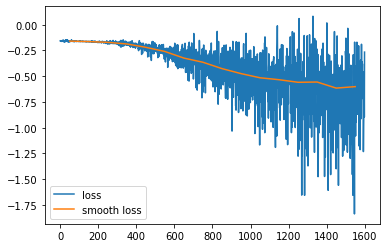

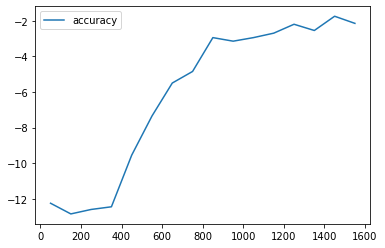

Running epoch 2
[2,   100] loss: 0.25095, accuracy: -2.05000
[2,   200] loss: 0.23301, accuracy: -1.35000
[2,   300] loss: 0.23797, accuracy: -1.75000
[2,   400] loss: 0.23446, accuracy: -1.80000
[2,   500] loss: 0.25598, accuracy: -1.55000
[2,   600] loss: 0.22531, accuracy: -1.80000
[2,   700] loss: 0.22419, accuracy: -1.30000
[2,   800] loss: 0.26801, accuracy: -1.55000
[2,   900] loss: 0.25725, accuracy: -1.80000
[2,  1000] loss: 0.19869, accuracy: -1.10000
[2,  1100] loss: 0.21628, accuracy: -1.65000
[2,  1200] loss: 0.24478, accuracy: -1.75000
[2,  1300] loss: 0.23247, accuracy: -1.20000
[2,  1400] loss: 0.21135, accuracy: -1.55000
[2,  1500] loss: 0.22291, accuracy: -1.05000
[2,  1600] loss: 0.21812, accuracy: -1.20000


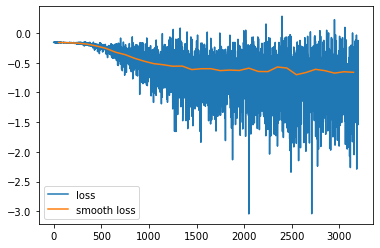

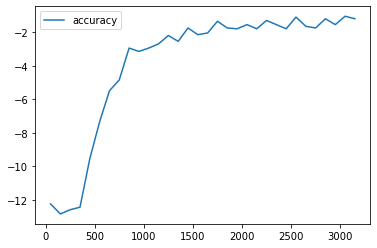

Running epoch 3
[3,   100] loss: 0.22467, accuracy: -1.30000
[3,   200] loss: 0.24036, accuracy: -1.95000
[3,   300] loss: 0.22816, accuracy: -1.35000
[3,   400] loss: 0.23247, accuracy: -1.25000
[3,   500] loss: 0.20237, accuracy: -1.35000
[3,   600] loss: 0.19987, accuracy: -1.10000
[3,   700] loss: 0.21451, accuracy: -1.50000
[3,   800] loss: 0.19607, accuracy: -1.10000
[3,   900] loss: 0.22374, accuracy: -1.10000
[3,  1000] loss: 0.18138, accuracy: -0.80000
[3,  1100] loss: 0.22904, accuracy: -1.30000
[3,  1200] loss: 0.19516, accuracy: -0.95000
[3,  1300] loss: 0.22913, accuracy: -1.45000
[3,  1400] loss: 0.20641, accuracy: -1.20000
[3,  1500] loss: 0.25110, accuracy: -1.55000
[3,  1600] loss: 0.21522, accuracy: -1.50000


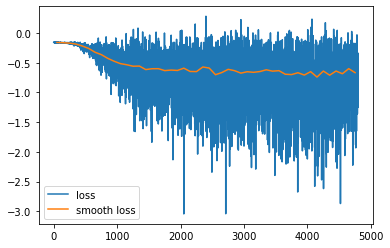

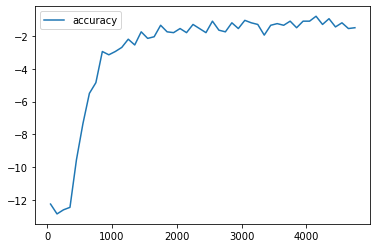

Running epoch 4
[4,   100] loss: 0.20922, accuracy: -1.10000
[4,   200] loss: 0.20335, accuracy: -1.35000
[4,   300] loss: 0.22001, accuracy: -1.35000
[4,   400] loss: 0.21729, accuracy: -1.20000
[4,   500] loss: 0.20046, accuracy: -1.25000
[4,   600] loss: 0.23987, accuracy: -1.25000
[4,   700] loss: 0.19959, accuracy: -1.10000
[4,   800] loss: 0.23136, accuracy: -1.75000
[4,   900] loss: 0.19687, accuracy: -0.95000
[4,  1000] loss: 0.20164, accuracy: -1.40000
[4,  1100] loss: 0.19806, accuracy: -1.40000
[4,  1200] loss: 0.21005, accuracy: -1.05000
[4,  1300] loss: 0.21717, accuracy: -1.65000
[4,  1400] loss: 0.18245, accuracy: -1.15000
[4,  1500] loss: 0.20992, accuracy: -1.10000
[4,  1600] loss: 0.21278, accuracy: -1.10000


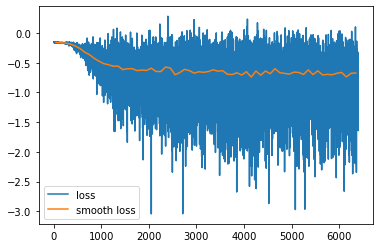

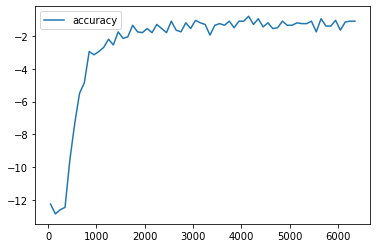

Running epoch 5
[5,   100] loss: 0.21777, accuracy: -1.55000
[5,   200] loss: 0.18178, accuracy: -1.05000
[5,   300] loss: 0.21925, accuracy: -1.50000
[5,   400] loss: 0.21713, accuracy: -1.00000
[5,   500] loss: 0.17758, accuracy: -1.30000
[5,   600] loss: 0.22533, accuracy: -1.25000
[5,   700] loss: 0.20938, accuracy: -0.85000
[5,   800] loss: 0.17802, accuracy: -1.45000
[5,   900] loss: 0.19276, accuracy: -1.30000
[5,  1000] loss: 0.22441, accuracy: -1.35000
[5,  1100] loss: 0.22030, accuracy: -1.30000
[5,  1200] loss: 0.19867, accuracy: -1.10000
[5,  1300] loss: 0.17421, accuracy: -0.85000
[5,  1400] loss: 0.21795, accuracy: -1.30000
[5,  1500] loss: 0.21749, accuracy: -1.10000
[5,  1600] loss: 0.20110, accuracy: -1.30000


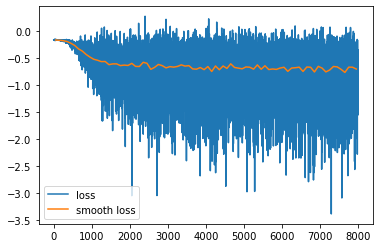

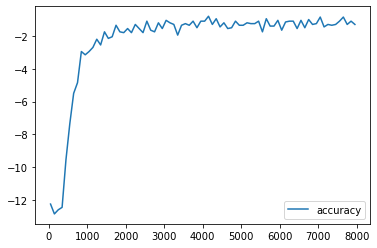

Running epoch 6
[6,   100] loss: 0.17049, accuracy: -1.35000
[6,   200] loss: 0.19281, accuracy: -1.30000
[6,   300] loss: 0.22110, accuracy: -1.70000
[6,   400] loss: 0.17875, accuracy: -1.00000
[6,   500] loss: 0.23721, accuracy: -1.35000
[6,   600] loss: 0.21358, accuracy: -1.25000
[6,   700] loss: 0.20707, accuracy: -1.30000
[6,   800] loss: 0.21251, accuracy: -1.15000
[6,   900] loss: 0.18572, accuracy: -1.50000
[6,  1000] loss: 0.19525, accuracy: -0.95000
[6,  1100] loss: 0.20316, accuracy: -0.95000
[6,  1200] loss: 0.23418, accuracy: -1.20000
[6,  1300] loss: 0.17730, accuracy: -1.15000
[6,  1400] loss: 0.20492, accuracy: -1.30000
[6,  1500] loss: 0.18743, accuracy: -0.90000
[6,  1600] loss: 0.18978, accuracy: -1.10000


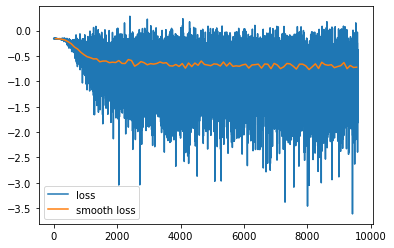

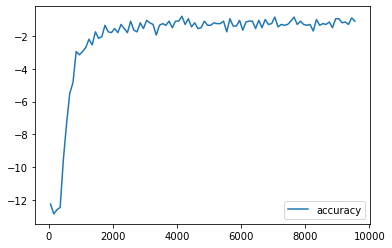

Running epoch 7
[7,   100] loss: 0.18270, accuracy: -1.20000
[7,   200] loss: 0.18383, accuracy: -1.45000
[7,   300] loss: 0.18314, accuracy: -1.20000
[7,   400] loss: 0.20994, accuracy: -1.35000
[7,   500] loss: 0.21248, accuracy: -1.35000
[7,   600] loss: 0.22185, accuracy: -1.15000
[7,   700] loss: 0.21537, accuracy: -1.35000
[7,   800] loss: 0.19120, accuracy: -1.05000
[7,   900] loss: 0.21967, accuracy: -1.20000
[7,  1000] loss: 0.22671, accuracy: -1.25000
[7,  1100] loss: 0.20855, accuracy: -1.35000
[7,  1200] loss: 0.15881, accuracy: -1.25000
[7,  1300] loss: 0.18325, accuracy: -0.65000
[7,  1400] loss: 0.20897, accuracy: -0.75000
[7,  1500] loss: 0.17448, accuracy: -1.05000
[7,  1600] loss: 0.18671, accuracy: -1.15000


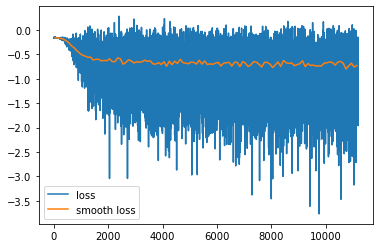

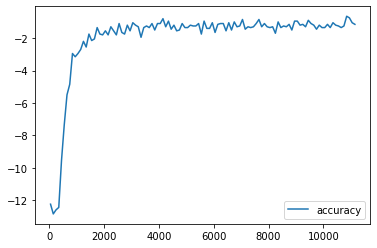

Running epoch 8
[8,   100] loss: 0.20656, accuracy: -1.25000
[8,   200] loss: 0.18948, accuracy: -1.10000
[8,   300] loss: 0.22403, accuracy: -1.00000
[8,   400] loss: 0.19604, accuracy: -1.10000
[8,   500] loss: 0.16450, accuracy: -0.95000
[8,   600] loss: 0.20760, accuracy: -1.20000
[8,   700] loss: 0.17472, accuracy: -1.30000
[8,   800] loss: 0.19406, accuracy: -0.80000
[8,   900] loss: 0.19574, accuracy: -1.80000
[8,  1000] loss: 0.16712, accuracy: -1.00000
[8,  1100] loss: 0.20417, accuracy: -1.10000
[8,  1200] loss: 0.22028, accuracy: -1.35000
[8,  1300] loss: 0.19545, accuracy: -1.05000
[8,  1400] loss: 0.18895, accuracy: -0.90000
[8,  1500] loss: 0.19729, accuracy: -1.55000
[8,  1600] loss: 0.19059, accuracy: -1.00000


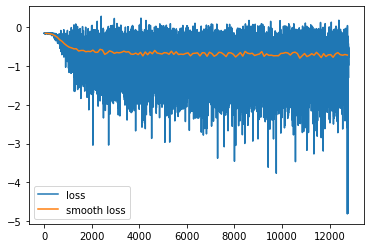

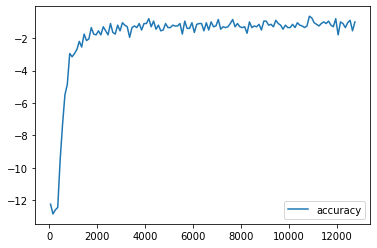

Running epoch 9
[9,   100] loss: 0.19121, accuracy: -1.10000
[9,   200] loss: 0.16715, accuracy: -0.95000
[9,   300] loss: 0.18167, accuracy: -1.20000
[9,   400] loss: 0.22044, accuracy: -1.20000
[9,   500] loss: 0.19111, accuracy: -0.80000
[9,   600] loss: 0.23626, accuracy: -1.55000
[9,   700] loss: 0.20413, accuracy: -1.20000
[9,   800] loss: 0.20215, accuracy: -1.15000
[9,   900] loss: 0.20183, accuracy: -1.25000
[9,  1000] loss: 0.20022, accuracy: -1.20000
[9,  1100] loss: 0.15805, accuracy: -0.90000
[9,  1200] loss: 0.19263, accuracy: -1.05000
[9,  1300] loss: 0.20536, accuracy: -1.15000
[9,  1400] loss: 0.18571, accuracy: -1.30000
[9,  1500] loss: 0.18896, accuracy: -1.20000
[9,  1600] loss: 0.16695, accuracy: -1.05000


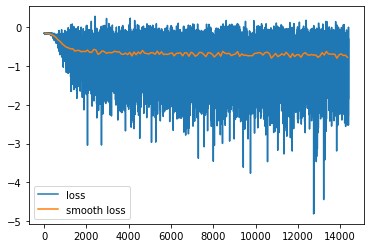

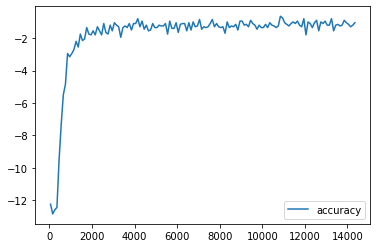

Running epoch 10
[10,   100] loss: 0.16714, accuracy: -1.10000
[10,   200] loss: 0.18610, accuracy: -1.00000
[10,   300] loss: 0.21351, accuracy: -1.20000
[10,   400] loss: 0.22761, accuracy: -1.30000
[10,   500] loss: 0.18933, accuracy: -0.90000
[10,   600] loss: 0.19090, accuracy: -1.05000
[10,   700] loss: 0.17822, accuracy: -1.25000
[10,   800] loss: 0.19422, accuracy: -1.15000
[10,   900] loss: 0.18343, accuracy: -0.95000
[10,  1000] loss: 0.17400, accuracy: -0.85000
[10,  1100] loss: 0.17508, accuracy: -1.15000
[10,  1200] loss: 0.20807, accuracy: -1.50000
[10,  1300] loss: 0.18915, accuracy: -1.20000
[10,  1400] loss: 0.18515, accuracy: -1.20000
[10,  1500] loss: 0.17977, accuracy: -1.25000
[10,  1600] loss: 0.21888, accuracy: -1.20000


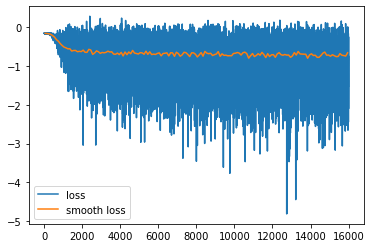

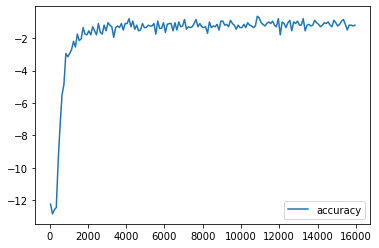

In [17]:
losses = []  

N_epochs = 10
n_verbose = 100
smooth_loss = []
accuracy = 0
acc_loss = []

for epoch in range(N_epochs):  # Loop over epochs
    print(f'Running epoch {epoch+1}')
    running_loss = 0.0
    for i, (features, label) in enumerate(TrainLoader):
        #print(features.shape)
        # Erase previous gradients
        optimizer.zero_grad()
        
        #print(features.shape)
        labels_pred =[]
        # Forward Propagation 
        labels_pred = model(features)  
        #print(labels_pred.shape)
        
        #print(labels_pred)
        #label = tensor(np.array(label[0].item()))   # for size 2 in output of the model
        #label = torch.tensor([label[0].item()]).to(torch.float)
        
        
        # Loss computation
        loss = loss_function(labels_pred, label[..., None])
        #val_loss = loss_function(labels_val_pred, labels_val)
        # Save loss for future analysis
        #losses.append(loss.item())
        #val_losses.append(val_loss)
        
        # Compute gradients (backpropagation)
        loss.backward()
        
        # Weight update
        optimizer.step()
        # ACcuracy:
        labels_pred[labels_pred<0.5] = 0
        labels_pred[labels_pred>=0.5] = 1

        accuracy = torch.add(accuracy, torch.sum(labels_pred-label))
        

        # print statistics
        running_loss += loss.item()
        losses.append(loss.item())
        if i % n_verbose == n_verbose-1:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / n_verbose:.5f}, accuracy: {accuracy/n_verbose:.5f}')
            smooth_loss.append(running_loss / n_verbose)
            acc_loss.append(accuracy.detach().numpy()/n_verbose)
            running_loss = 0.0
            accuracy = 0.
    plt.plot(np.log10(np.array(losses)), label = 'loss')
    plt.plot(np.arange(len(smooth_loss))*n_verbose+n_verbose/2., np.log10(np.array(smooth_loss)), label='smooth loss')
    #plt.ylim([0,1])
    plt.legend()
    plt.show()
    plt.plot(np.arange(len(smooth_loss))*n_verbose+n_verbose/2., np.array(acc_loss), label = 'accuracy')
    plt.legend()
    plt.show()
    

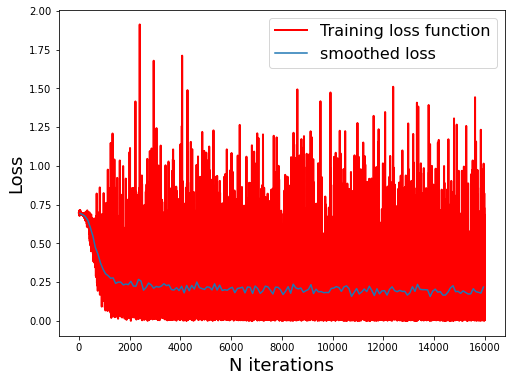

In [18]:
# Display loss evolution
fig, axes = plt.subplots(figsize=(8,6))
axes.plot(losses,'r-',lw=2,label='Training loss function')
plt.plot(np.arange(len(smooth_loss))*n_verbose+n_verbose/2., (np.array(smooth_loss)), label = 'smoothed loss')
#axes.plot(val_losses,'b-',lw=2,label='Validation loss function')
axes.set_xlabel('N iterations',fontsize=18)
axes.set_ylabel('Loss',fontsize=18)
#plt.ylim([0, 1])
plt.legend(loc='upper right',fontsize=16)

In [19]:
val_losses = []
for epoch in range(N_epochs):  # Loop over epochs
    running_loss = 0.0
   
    for features, labels in ValLoader:
        
        # Forward Propagation 
        labels_pred = model(features.double())
        label = torch.tensor([labels[0].item()]).to(torch.double)

        # Loss computation
        loss = loss_function(labels_pred, label)

        # Save loss for future analysis
        val_losses.append(loss.item())
        
    print('Training done')

ValueError: Target size (torch.Size([1])) must be the same as input size (torch.Size([16, 1]))

In [ ]:
# Accuracy
def accuracy(model,dataloader):
    correct = 0
    total = 0
    # No need to compute gradients here
    with torch.no_grad():
        for features, labels in dataloader:
            print(len(labels))
            # Forward propagation to get predictions
            pred = model(features.float()) 
            otherprob = 1 - pred.item()           
            outputs = torch.tensor([[pred, otherprob]])
            labels = torch.tensor([labels[0].item()]).to(torch.float)
            print(labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            #print(total)
            correct += (predicted == labels).sum().item()
    return 100.0 * correct / total       

print('Accuracy : %.2f %%' % (accuracy(model,TestLoader)))   